In [6]:
import sys, subprocess

def is_colab():
    return "google.colab" in sys.modules

In [7]:
class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render(mode='rgb_array')
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

In [8]:
colab_requirements = [
    "gym",
    "numpy",
    "pandas",
    "seaborn",
    "pyvirtualdisplay",
    "imageio",
    "nnfigs",
    "box2d-py"
]

debian_packages = [
    "xvfb",
    "x11-utils"
]

if is_colab():

    def run_subprocess_command(cmd):
        # run the command
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
        # print the output
        for line in process.stdout:
            print(line.decode().strip())

    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

    for i in debian_packages:
        run_subprocess_command("apt install " + i)

In [25]:
import gym
import numpy as np
from scipy.special import softmax
import progressbar

In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import time
import imageio
import IPython
from IPython.display import Image

In [11]:
if "google.colab" in sys.modules:
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

In [12]:
def xavier_init(n_in, n_out, layer=1):
    #return np.random.normal(0, 1/(n_in**(layer - 1)), size = (n_in, n_out))
    glorot = 1.0*np.sqrt(6.0/(n_in+n_out))
    return np.random.uniform(-glorot,glorot,size=(n_in,n_out))
    

In [48]:
class Agent():
    
    def __init__(self, n_input, n_hidden, n_hidden2, n_output, mu_prob):
        
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
        self.mu_prob = mu_prob
        self.network = {'Layer 1' : xavier_init(n_input, n_hidden , layer = 1),
                        'Bias 1'  : np.zeros((1,n_hidden)),
                        'Layer 2' : xavier_init(n_hidden, n_hidden2 , layer = 2),
                        'Bias 2'  : np.zeros((1,n_hidden2)),
                        'Layer 3': xavier_init(n_hidden2, n_output , layer = 3),
                        'Bias 3': np.zeros((1, n_output))}
        self.score = 0
        
    def reborn(self, parents):
        #The agent reborns with a recombination of its parents parameters
        parent1, parent2 = parents
        for key in self.network:
            mask = np.random.choice([0,1],size=self.network[key].shape,p=[.5,.5])
            self.network[key] = np.where(mask==1,parent1.network[key],parent2.network[key])
            #if np.random.random() > 0.5:
            #    self.network[node] = parent1.network[node]
            #else:
            #    self.network[node] = parent2.network[node]
                
    def mutate(self):
        for key in self.network:
            mask = np.random.choice([0,1],size=self.network[key].shape,p=[1-self.mu_prob,self.mu_prob])
            random = xavier_init(mask.shape[0],mask.shape[1])
            self.network[key] = np.where(mask==1,self.network[key]+random,self.network[key])
            #if np.random.random() > self.mu_prob:
            #    self.network[node] += np.random.normal(0, 0.05 * np.abs(self.network[node]) )
                #if np.argwhere(np.isnan(self.network[node])):
                #    print("nanNode")
    
    def act(self, state):
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        net = self.network
        layer_one = np.tanh(np.dot(state,net['Layer 1']) + net['Bias 1'])
        layer_two = np.tanh(np.dot(layer_one, net['Layer 2']) + net['Bias 2'])
        layer_three = np.tanh(np.dot(layer_two, net['Layer 3']) + net['Bias 3'])
        #print(layer_two, layer_two[0])
        return layer_three[0]
        

        
    def evaluate(self, env):
        scores = []
        for i in range(1):
            state = env.reset()
            score = 0
            done = False
            while not done:
                state, reward, done, _ = env.step(self.act(state))
                score += reward
            #print(score)
            scores.append(score)
        self.score = sum(scores)
        #print(self.score)
        
    
        
    def evaluate_using_RNN(self, model, env):
        scores = []
        
        for i in range(1):
            state = env.reset()
            score = 0
            done = False
            while not done:
                state, reward, done = model.predict(np.concatenate(self.act(state)), state)
                score += reward
            #print(score)
            scores.append(score)
        self.score = sum(scores)
        
    def collect_samples(self, env, n_episodes, n_steps):
        
        samples = []
        bar = progressbar.ProgressBar( maxval=n_episodes)
        bar.start()


        for i in range(n_episodes):
            state = env.reset()
            done = False
            episode_samples = []
            reward = 0 
            for step in range(n_steps):
                if not done:
                    action = self.act(state)
                    episode_samples.append( np.concatenate((action, state , [reward], [done]))) # Collect Si, Ai, Ri 
                    state, reward, done, _ = env.step(self.act(state))
                else:
                    episode_samples.append( np.concatenate((action, state,  [reward], [done]))) # Collect Si, Ai, Ri 
                    reward = 0
            
            samples.append(episode_samples)
            bar.update(i)
        bar.finish()
        
        return samples
                

In [38]:
def select_next_gen(agent_set,n_selected):
    n_best = int(n_selected*0.8)
    n_random = n_selected - n_best
    sorted_agents = sorted(agent_set, key = lambda agent : agent.score, reverse = True)
    #for agent in sorted_agents:
     #   print(agent.score)
    next_gen = sorted_agents[:n_best]
    next_random = np.random.choice(sorted_agents, size = n_random, replace = False)
    for rand in next_random:
        next_gen.append(rand)
    not_selected = []
    for agent in agent_set:
        #print(next_gen)
        #print("ee")
        if agent not in next_gen:
            not_selected.append(agent)
    return sorted_agents[0], next_gen, not_selected




def select_parents(agent_set):
    return np.random.choice(agent_set, size = 2, p = softmax([agent.score for agent in agent_set]))

In [39]:
env = gym.make('BipedalWalker-v3')
#RenderWrapper.register(env, force_gif=True)

done = False



#Algorithm parameter
n_input = env.observation_space.shape[0]
n_output = env.action_space.shape[0]
n_hidden = 128
n_hidden2 = 64

mu_prob = 0.15
generation = 80
population = 60

prop_selected = 0.3


/anaconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [40]:
import time

In [41]:
n_selected = int(prop_selected * population)
best_agents = []
agent_set = [Agent(n_input, n_hidden,n_hidden2, n_output, mu_prob) for i in range(population)]
best, selected, next_children = select_next_gen(agent_set, n_selected)

best_agents.append(best)


for gen in range(1, generation):
    time_gen1 = time.time()
    for new_child in next_children:
        #time1 = time.time()
        parents = select_parents(selected)
        #time2 = time.time()
        #print("Time for select_parents:", time2-time1)
        new_child.reborn(parents)
        #time3 = time.time()
        #print("Time reborn:", time3-time2)
        new_child.mutate()
        #time4 = time.time()
        #print("Time for mutate:", time4 -time3)
        #new_child.evaluate(env)
        #time5 = time.time()
        #print("Time for evaluate:", time5-time4)
    for agent in agent_set:
      agent.evaluate(env)
    best, selected, next_children = select_next_gen(agent_set, n_selected)
    best_agents.append(best)
    time_gen2 = time.time()
    print("Generation:",gen,"Score:",best.score)
    print("Time for generation:", time_gen2 - time_gen1)


KeyboardInterrupt: 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


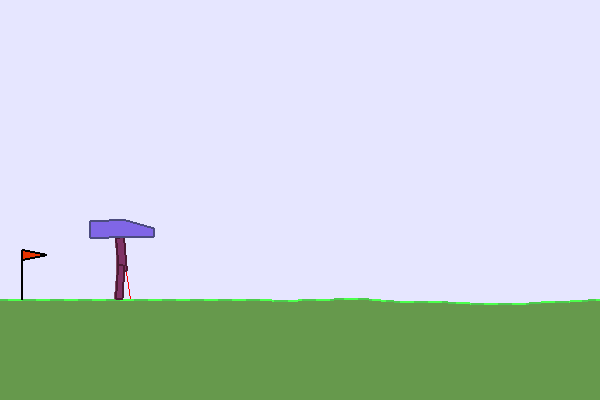

In [15]:
# Record every agent
env = gym.make('BipedalWalker-v3')
RenderWrapper.register(env, force_gif=True)

observation = env.reset()
done = False


#for agent in best[generation - 5:generation -1]:
observation = env.reset()
for t in range(1000):
    env.render_wrapper.render()


    observation, reward, done, info = env.step(best_agents[78].act(observation))

    ### END SOLUTION ###


print()
env.close()

env.render_wrapper.make_gif("Evolution")

# Training and testing the RNN

In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [97]:
""" Make a random agent collect samples of the interaction with the environement"""
n_episodes = 1000
n_steps = 1000

batch_size = 64
n_epochs = 20



agent = Agent(n_input, n_hidden,n_hidden2, n_output, mu_prob)
env = gym.make('BipedalWalker-v3')

print("Collecting samples ...")
samples = np.array(agent.collect_samples(env, n_episodes, n_steps))

inputs = samples[:,:-1,:28] #Inputs are states and actions

outputs = samples[:,-1, 4:] #Outputs are states, rewards, and done

""" Train the RNN on these samples"""


model = Sequential()

model.add(LSTM(128, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

model.add(Dense(26, activation='softmax'))

model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

print("Training RNN ...")


model.fit(inputs,  outputs, batch_size=batch_size, epochs=n_epochs)



/anaconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


100% |########################################################################|


Training RNN ...
Epoch 1/20
1000/1000 [==============================] - 32s 32ms/step - loss: 0.2204 - accuracy: 0.8790
Epoch 2/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.1982 - accuracy: 0.7310
Epoch 3/20
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1972 - accuracy: 0.9740
Epoch 4/20
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1966 - accuracy: 1.0000
Epoch 5/20
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1962 - accuracy: 1.0000
Epoch 6/20
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1957 - accuracy: 0.9990
Epoch 7/20
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1955 - accuracy: 0.9980
Epoch 8/20
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1951 - accuracy: 0.9950
Epoch 9/20
1000/1000 [==============================] - 32s 32ms/step - loss: 0.1950 - accuracy: 0.9960
Epoch 10/20
1000/1000 [========================

In [98]:
""" To compare the prediction of the RNN with gym"""

test_sample = np.array(agent.collect_samples(env, 1, n_steps))
#print(test_sample[0][-1])

next_action = test_sample[0,-1,:4]
current_state = test_sample[0,-1,4:24]
#print(next_action)
test_input = np.reshape(test_sample[:,:999,:28], (1, 999,28))



print(env.step(next_action))

#test_input =  np.concatenate(([1,0,0,1], state))
#filler = np.zeros((99, len(test_input)))
#print(filler.shape)

#filler[98,:] = test_input

#print(filler[-2])
#final_input = np.reshape(test_sample, (1, 100,28))

print(model.predict(test_input))

100% |########################################################################|


(array([ 1.11741520e-01, -6.45664613e-08,  2.08030747e-07,  2.27255296e-07,
        1.13492894e+00,  5.40599103e-08,  9.34907913e-01,  1.59874768e-08,
        1.00000000e+00, -8.34919393e-01, -1.68481051e-09,  9.16206837e-02,
        9.66321750e-07,  0.00000000e+00,  2.38621250e-01,  2.41331145e-01,
        2.49777168e-01,  2.65003085e-01,  2.89120257e-01,  3.26123923e-01,
        3.83876145e-01,  4.79572207e-01,  6.58523917e-01,  1.00000000e+00]), -0.03420551608983202, False, {})
[[1.6336307e-05 6.9090593e-06 2.2066059e-05 8.1474791e-06 5.2206391e-01
  1.8645746e-05 3.0160441e-05 1.7655591e-05 1.5083328e-04 7.0714932e-06
  9.3309627e-06 1.0316385e-05 7.8769053e-06 1.6181169e-03 5.0843300e-06
  4.7914444e-05 7.8091543e-06 1.1837194e-05 8.7775234e-06 5.8065702e-06
  1.1638747e-05 5.0896550e-05 7.5719543e-02 4.0012723e-01 6.1708138e-06
  9.8001628e-06]]


In [ ]:
"""Train the agent using the RNN"""
n_selected = int(prop_selected * population)
best_agents = []
agent_set = [Agent(n_input, n_hidden,n_hidden2, n_output, mu_prob) for i in range(population)]
best, selected, next_children = select_next_gen(agent_set, n_selected)

best_agents.append(best)


for gen in range(1, generation):
    time_gen1 = time.time()
    for new_child in next_children:
        #time1 = time.time()
        parents = select_parents(selected)
        #time2 = time.time()
        #print("Time for select_parents:", time2-time1)
        new_child.reborn(parents)
        #time3 = time.time()
        #print("Time reborn:", time3-time2)
        new_child.mutate()
        #time4 = time.time()
        #print("Time for mutate:", time4 -time3)
        #new_child.evaluate(env)
        #time5 = time.time()
        #print("Time for evaluate:", time5-time4)
    for agent in agent_set:
        agent.evaluate_using_RNN(model, env)
    best, selected, next_children = select_next_gen(agent_set, n_selected)
    best_agents.append(best)
    time_gen2 = time.time()
    print("Generation:",gen,"Score:",best.score)
    print("Time for generation:", time_gen2 - time_gen1)


In [35]:
a = [[1,2],[3,4]]
b = [[4,5,6], [7,8,9]]

np.concatenate((a,b), axis = 1)

array([[1, 2, 4, 5, 6],
       [3, 4, 7, 8, 9]])